# Build Churn Prediction Model (sklearn)

### Executive summary and business lessons
Three algorithms --- logistic regression, random forest, and gradient boosting --- are evaluated. Logistic regression serves as an acceptable baseline with AUC ~= 0.86, while the ensemble tree models managed ~=0.90. In particular, all three models reported similar recall rates (0.89-0.90) while the ensemble trees achieved 5% higher precision; that may be the source of their higher AUCs. Also, similar recall, higher precision $\rightarrow$ less false positives.

Also tried perceptrons (neural networks), which gave a worse performance across the board. Given the superb performance of simpler models, it's not worth tuning the neural network further.

**Lesson**: Recall should be the key measure here; since all three models perform similarly, we should go with logistic regression because it runs the quickest. False positives, i.e. false predictions of churns, shouldn't matter --- at worst, users would ignore attempts to retain them with discounts, and at best they might actually bite the bait!

From examining **feature importances** of the random forest, it seems that play events --- not searches or downloads --- are the key factors correlated with churning (or not). On the other hand, user device (Android VS iOS) is the weakest feature out of all. 

**Lesson**: focus on improving frontend/overall product quality, instead of looking for platform-specific bugs!

## Load data; final check of integrity
Notice how we are not scaling or normalizing the data; for the tree-based models we use, it definitely doesn't matter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

In [2]:
# Load data from file
df = pd.read_csv('../data/df_model_final.csv')

In [3]:
# Browse dataset
df.head(10)

,uid,label,freq_P_last_1,freq_P_last_3,freq_P_last_7,freq_P_last_14,freq_P_last_30,freq_D_last_1,freq_D_last_3,freq_D_last_7,...,freq_S_last_30,recency_P,recency_D,recency_S,play_time_last_1,play_time_last_3,play_time_last_7,play_time_last_14,play_time_last_30,device_type
0,34509854,1,7,11,11,11,141,0,0,0,...,0,1.0,0.0,0.0,4859.0,5803.0,5803.0,5803.0,64117.0,2
1,87772572,0,0,47,168,411,514,0,0,0,...,15,2.0,0.0,3.0,0.0,3208.0,13282.0,40604.0,50403.0,2
2,107648598,1,0,0,0,0,2,0,0,0,...,0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,2
3,148769344,1,0,0,0,0,3,0,0,0,...,3,29.0,0.0,10.0,0.0,0.0,0.0,0.0,489.0,2
4,166225978,1,0,0,0,0,182,0,0,0,...,34,26.0,28.0,26.0,0.0,0.0,0.0,0.0,2784.0,2
5,167519583,0,0,0,0,0,24,0,0,0,...,0,27.0,30.0,0.0,0.0,0.0,0.0,0.0,192.0,2
6,167570672,1,0,0,30,126,305,0,0,0,...,0,6.0,0.0,0.0,0.0,0.0,7051.0,28619.0,68783.0,2
7,167574168,1,0,0,0,0,36,0,0,0,...,0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,6725.0,2
8,167584251,1,0,0,0,0,17,0,0,0,...,0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,336.0,2
9,167587488,1,0,0,0,0,39,0,0,0,...,0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,5730.0,2


In [4]:
'''
    Summary stats: see what doesn't make sense (Fortunately not)
'''
df.describe()

,uid,label,freq_P_last_1,freq_P_last_3,freq_P_last_7,freq_P_last_14,freq_P_last_30,freq_D_last_1,freq_D_last_3,freq_D_last_7,...,freq_S_last_30,recency_P,recency_D,recency_S,play_time_last_1,play_time_last_3,play_time_last_7,play_time_last_14,play_time_last_30,device_type
count,6.309000e+04,63090.000000,63090.000000,63090.000000,63090.000000,63090.000000,63090.000000,63090.000000,63090.000000,63090.000000,...,63090.000000,63090.000000,63090.000000,63090.000000,6.309000e+04,6.309000e+04,6.309000e+04,6.309000e+04,6.309000e+04,63090.000000
mean,1.674342e+08,0.627310,2.858282,8.933539,19.981756,43.330987,123.162086,0.131194,0.315676,0.775686,...,9.983595,16.322032,7.349200,9.874053,6.034473e+02,1.959897e+03,4.454819e+03,9.689490e+03,2.830828e+04,1.876906
std,1.009333e+07,0.483524,13.262623,30.975148,57.404767,105.988681,219.926355,6.391645,7.497217,11.453345,...,25.401049,11.474796,11.180206,11.778503,8.712624e+03,2.243979e+04,5.402676e+04,9.003769e+04,2.183300e+05,0.338012
min,1.233300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,1.680387e+08,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.170000e+02,2.000000
50%,1.684978e+08,1.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000,0.000000,...,1.000000,17.000000,0.000000,3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.841000e+03,2.000000
75%,1.687798e+08,1.000000,0.000000,0.000000,8.000000,31.000000,135.000000,0.000000,0.000000,0.000000,...,9.000000,29.000000,14.000000,21.000000,0.000000e+00,0.000000e+00,8.677500e+02,3.784000e+03,1.899050e+04,2.000000
max,1.692516e+08,1.000000,466.000000,983.000000,1523.000000,1657.000000,2063.000000,1493.000000,1493.000000,1493.000000,...,1361.000000,30.000000,30.000000,30.000000,1.173572e+06,2.650887e+06,6.576376e+06,1.220810e+07,2.936766e+07,3.000000


## Define Features and Target Variables

In [8]:
# One-hot encode device_type
df['device_type_1'] = (df['device_type'] == 1).astype(int)
df['device_type_2'] = (df['device_type'] == 2).astype(int)
df['device_type_3'] = (df['device_type'] == 3).astype(int)

In [6]:
# Obtain list of column names 
# Take away irrelevant features, and the label itself
selected_features = df.columns.difference(["uid", "label", "device_type"])

In [9]:
# Define X: features, y: label
X = df[selected_features]
y = df['label']

In [21]:
X.shape

(62751, 26)

In [22]:
y[:10]

0    0
1    1
2    1
3    1
4    0
5    0
6    1
7    1
8    1
9    1
Name: label, dtype: int64

## Split into training and test sets!

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train and Evaluate Models
First, define helper functions that
1. Fit a *given* sklearn model object
2. Plot ROC for getting an intuitive understanding of model performance
3. Compute various metric scores

In [11]:
def train_test_model(clf, X_train, y_train, X_test, y_test):
    '''
        Take sklearn model object (clf), fit it, and evaluate on test set
    '''
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)
    

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    '''
        Helper function for plotting ROC in train_test_model()
    '''
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
# Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

### Let the models fly!

Parameters are hand-tuned in this section; cross-validation will follow later

**Punch lines**: 
- With the exception of perceptrons, all models evaluated achieved training/testing AUCs of at least 0.88!
- There's barely any overfitting!

Random forest and gradient boosting are performing slightly better than logistic regression (+0.02 AUC), but logistic regression may be preferable when performance is absolutely key.

### Logistic Regression

              train      test
metrics                      
AUC        0.867016  0.867617
Accuracy   0.805734  0.806388
Precision  0.805285  0.809561
Recall     0.909890  0.906281
f1-score   0.854398  0.855195


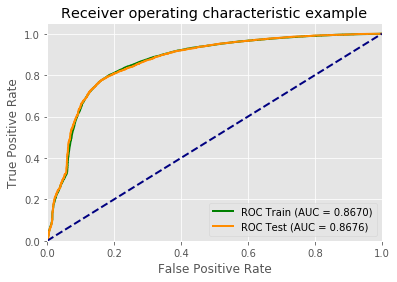

In [13]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize model by providing parameters
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(C=1.0, penalty='l2')
# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

### Random Forest

              train      test
metrics                      
AUC        0.921821  0.904017
Accuracy   0.848094  0.836662
Precision  0.857420  0.850755
Recall     0.908593  0.898744
f1-score   0.882265  0.874091


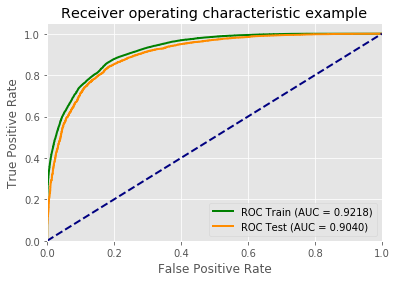

In [14]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

# Choose some parameter combinations to try
parameters = {'n_estimators': 50,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

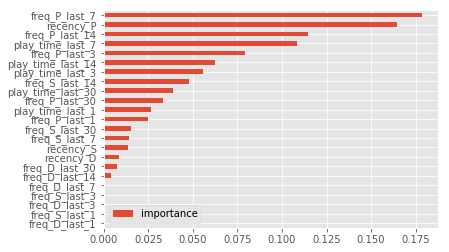

In [15]:
'''
    Which features allow us to best predict churning? The various aspects of play events.
    On the other hand, it doesn't matter whether users access the platform using Android
    or iOS devices. Focus on improving product quality, instead of finding platform specific bugs! 
'''

df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = selected_features
df_feature_importance['importance'] = clf.feature_importances_
df_feature_importance.sort_values('importance',inplace=True)

ax = df_feature_importance.plot.barh()
t = np.arange(len(df_feature_importance['feature']))
ax.set_yticks(t)
ax.set_yticklabels(df_feature_importance['feature'])
plt.show()

### Gradient Boosting Trees

              train      test
metrics                      
AUC        0.914006  0.903668
Accuracy   0.846984  0.835473
Precision  0.858898  0.851746
Recall     0.904292  0.894975
f1-score   0.881011  0.872825


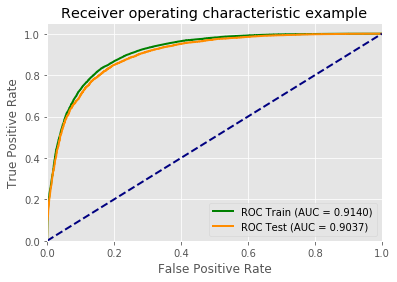

In [16]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'random_state': 42
}

# parameters = {
#     'n_estimators': 50,
#     'max_depth': 5,
#     'learning_rate': 0.2,
#     'subsample': 0.7,
#     'max_features':0.8,
#     'random_state': 42
# }

clf = GradientBoostingClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

### Perceptrons (Neural Network)
Consider that we haven't scaled our data, neural networks are expected to perform poorly. Changing  `random_state` from 0 to 12 allieviated the performance issue somewhat, but that's not a robust solution! 

Moreoever, when 'traditional' ML methods are performing quite well already, there is no reason to play with complicated models e.g. neural networks.

              train      test
metrics                      
AUC        0.862081  0.860848
Accuracy   0.771220  0.768822
Precision  0.888261  0.885256
Recall     0.726128  0.727889
f1-score   0.799053  0.798897


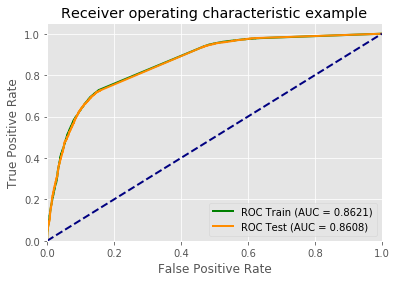

In [21]:
# http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
from sklearn.neural_network import MLPClassifier

# Choose some parameter combinations to try
parameters = {
    'solver':'adam', 
    'activation':'relu',
    'alpha':1e-5, #increase alpha->increase penalty :: http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py
    'hidden_layer_sizes':(10,7,3), 
    'learning_rate':'adaptive',
    'random_state':12
    }
clf = MLPClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

### HyperParameter Tuning: Grid Search
Let's see if we can squeeze even more performance out of our models via cross-validation and grid search. Performed for RandomForest only; same procedure for other models.

**Punch line**: ironically, RF is now slightly overfitting on the training set, even though the test AUC hasn't changed much.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [100,200], 
              'max_features': ['auto'], 
              'criterion': ['gini'],
              'max_depth': [15,20,25], 
              'min_samples_split': [2],
              'min_samples_leaf': [2,10,20],
              'n_jobs':[-1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(roc_auc_score)

# Run the grid search
# read theory
grid_obj = GridSearchCV(clf, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              train      test
metrics                      
AUC        0.935607  0.904595
Accuracy   0.861904  0.837375
Precision  0.869487  0.853180
Recall     0.917228  0.896482
f1-score   0.892720  0.874296


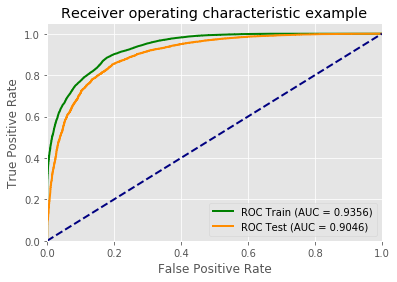

In [19]:
# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)